<font size="+3">COVID-19 Exploratory Data Analysis</font>

# Import modules and load data

We begin by making some imports, including `coronavirus_data.py`, a module written to collect the latest data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime
from scipy.optimize import curve_fit
import seaborn as sns
import coronavirus_data
import elegant_plots as ep

plt.style.use('maxistyle')

Next, we'll get the latest data, sourced from **Johns Hopkins University**, and save it to our csv files so we don't have to download the data each time.

In [2]:
coronavirus_data.update_all_data()

Updating global_cases.csv
Updating global_deaths.csv
Updating global_recovered.csv
Updating usa_cases.csv
Updating usa_deaths.csv


There are five different datasets: **Global confirmed cases**, **Global deaths**, **Global confirmed recoveries**, **USA confirmed cases** and **USA deaths**. We will store each as a pandas dataframe for easier data manipulation. We'll also make some adjustments to the column names for easier reference.

It is important to note that some countries and provinces are not included in the global confirmed recoveries dataset.

In [3]:
global_cases = pd.read_csv('data/global_cases.csv')
global_cases.rename(columns={'Province/State': 'province', 'Country/Region': 'country'}, inplace=True)
global_deaths = pd.read_csv('data/global_deaths.csv')
global_deaths.rename(columns={'Province/State': 'province', 'Country/Region': 'country'}, inplace=True)
global_recovered = pd.read_csv('data/global_recovered.csv')
global_recovered.rename(columns={'Province/State': 'province', 'Country/Region': 'country'}, inplace=True)

In [4]:
# Read USA data, do some qol stuff, drop a few unneeded columns
usa_cases = pd.read_csv('data/usa_cases.csv')
usa_cases.rename(columns={'Admin2': 'county', 'Province_State': 'state', 'Country_Region': 'country', 'Long_': 'Long'}, inplace=True)
usa_cases.drop(columns=['UID', 'iso2', 'code3', 'country'], inplace=True)
usa_deaths = pd.read_csv('data/usa_deaths.csv')
usa_deaths.rename(columns={'Admin2': 'county', 'Province_State': 'state', 'Country_Region': 'country', 'Long_': 'Long', 'Population': 'population'}, inplace=True)
usa_deaths.drop(columns=['UID', 'iso2', 'code3', 'country'], inplace=True)

# Global cases, deaths and recoveries

## Initial data cleaning

Let's begin by looking at a snapshot of the global cases dataframe.

In [5]:
global_cases.head()

,province,country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,273,281,299,349,367,423,444,484,521,555
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,277,304,333,361,377,383,400,409,416,433
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,986,1171,1251,1320,1423,1468,1572,1666,1761,1825
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,428,439,466,501,525,545,564,583,601,601
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,8,8,10,14,16,17,19,19,19,19


We can see the general structure of the data; each row seems to be a country, with the number of confirmed cases represented as its own column for each date.

Having the dates represented as separate columns is good for keeping a dataset small but makes it pretty tricky to plot timeseries data. Having the data represented like this also makes it harder to quickly see a country's cases and deaths and recoveries, since they are in different dataframes.

So let's create a single `'Date'` column and transform the dataframe into one that has a new column for each date and province:

In [6]:
def transform_df(df, measured_val='Cases'):
    dict = {'province': [], 'country': [], 'Date': [], 'Lat': [], 'Long': [], measured_val: []}
    for index, row in df.iterrows():
        columns = list(df)
        for i, value in enumerate(row[4:]):
            dict['province'].append(row['province'])
            dict['country'].append(row['country'])
            dict['Date'].append(columns[i+4])
            dict['Lat'].append(row['Lat'])
            dict['Long'].append(row['Long'])
            dict[measured_val].append(value)
    new_df = pd.DataFrame(data=dict)
    return new_df

global_cases = transform_df(global_cases)
global_deaths = transform_df(global_deaths, measured_val='Deaths')
global_recovered = transform_df(global_recovered, measured_val='Recovered')

Okay. Now let's run the `info` method to see whether there are any `NaN` values that are interesting.

In [7]:
global_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21384 entries, 0 to 21383
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   province  6642 non-null   object 
 1   country   21384 non-null  object 
 2   Date      21384 non-null  object 
 3   Lat       21384 non-null  float64
 4   Long      21384 non-null  float64
 5   Cases     21384 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 1002.5+ KB


We can see that the **only column that has Null values (NaN) is provinces**. Let's take a closer look there by extracting just the rows which have province values and seeing which countries have province data.

In [8]:
province_data = global_cases[-global_cases['province'].isna()]
countries_with_provinces = province_data['country'].unique()
countries_with_provinces

array(['Australia', 'Canada', 'China', 'Denmark', 'France', 'Netherlands',
       'United Kingdom'], dtype=object)

We can then see the provinces for each of these countries individually:

In [9]:
province_data[province_data['country'] == 'Denmark']

,province,country,Date,Lat,Long,Cases
7452,Faroe Islands,Denmark,1/22/20,61.8926,-6.9118,0
7453,Faroe Islands,Denmark,1/23/20,61.8926,-6.9118,0
7454,Faroe Islands,Denmark,1/24/20,61.8926,-6.9118,0
7455,Faroe Islands,Denmark,1/25/20,61.8926,-6.9118,0
7456,Faroe Islands,Denmark,1/26/20,61.8926,-6.9118,0
...,...,...,...,...,...,...
7609,Greenland,Denmark,4/7/20,71.7069,-42.6043,11
7610,Greenland,Denmark,4/8/20,71.7069,-42.6043,11
7611,Greenland,Denmark,4/9/20,71.7069,-42.6043,11
7612,Greenland,Denmark,4/10/20,71.7069,-42.6043,11


Looking through each country and their "provinces" we find that:
* **Australia, Canada and China** all have legitimate provinces - i.e. they are subsections of the country - *let's keep these*
* **Canada** has a few others: **'Diamond Princess', 'Grand Princess', 'Recovered'** - these are not representative of the country - *let's drop these*
* **China** also has data for **Hong Kong**, which is often treated as separate from China - *let's consider this as its own "country"*
* **UK, France, Netherlands, Denmark** have overseas territories that we probably don't want to include in the national statistics - *let's consider these as their own "countries"*

In [10]:
for country in ['United Kingdom', 'France', 'Denmark', 'Netherlands']:
    provinces = province_data[province_data['country'] == country]['province'].unique()
    for province in provinces:
        global_cases.loc[global_cases['province'] == province, ['country', 'province']] = province, np.nan
        global_deaths.loc[global_deaths['province'] == province, ['country', 'province']] = province, np.nan
        global_recovered.loc[global_recovered['province'] == province, ['country', 'province']] = province, np.nan
        
# drop weird Canada provinces
for province in ['Diamond Princess', 'Grand Princess', 'Recovered']:
        global_cases = global_cases[global_cases['province'] != province]
        global_deaths = global_deaths[global_deaths['province'] != province]
        global_recovered = global_recovered[global_recovered['province'] != province]
        
# make Hong Kong its own 'country' - wow what a democrat I am...
province = 'Hong Kong'
global_cases.loc[global_cases['province'] == province, ['country', 'province']] = province, np.nan
global_deaths.loc[global_deaths['province'] == province, ['country', 'province']] = province, np.nan
global_recovered.loc[global_recovered['province'] == province, ['country', 'province']] = province, np.nan

Let's see if that worked:

In [11]:
global_cases[global_cases['country'].isin(['United Kingdom', 'France', 'Netherlands', 'Denmark', 'Hong Kong', 'Aruba', 'French Polynesia'])]

,province,country,Date,Lat,Long,Cases
4941,NaN,Hong Kong,1/22/20,22.3000,114.200,0
4942,NaN,Hong Kong,1/23/20,22.3000,114.200,2
4943,NaN,Hong Kong,1/24/20,22.3000,114.200,2
4944,NaN,Hong Kong,1/25/20,22.3000,114.200,5
4945,NaN,Hong Kong,1/26/20,22.3000,114.200,8
...,...,...,...,...,...,...
18139,NaN,United Kingdom,4/7/20,55.3781,-3.436,55242
18140,NaN,United Kingdom,4/8/20,55.3781,-3.436,60733
18141,NaN,United Kingdom,4/9/20,55.3781,-3.436,65077
18142,NaN,United Kingdom,4/10/20,55.3781,-3.436,73758


They are all their own countries now - great! :)

Finally, let's merge the confirmed cases and deaths dataframes to more easily handle the data:

In [12]:
df = global_cases.merge(global_deaths)
df['Date'] = pd.to_datetime(df['Date']) # Not going to merge recovered because some important countries don't have data for this, others only have data for the country as a whole... Might do it later :)
df.head(2)

,province,country,Date,Lat,Long,Cases,Deaths
0,NaN,Afghanistan,2020-01-22,33.0,65.0,0,0
1,NaN,Afghanistan,2020-01-23,33.0,65.0,0,0


## Data exploration

Let's run a quick correlation matrix on our data and create a heatmap

             Lat      Long     Cases    Deaths
Lat     1.000000 -0.124657  0.068970  0.065039
Long   -0.124657  1.000000 -0.016214 -0.013615
Cases   0.068970 -0.016214  1.000000  0.835253
Deaths  0.065039 -0.013615  0.835253  1.000000


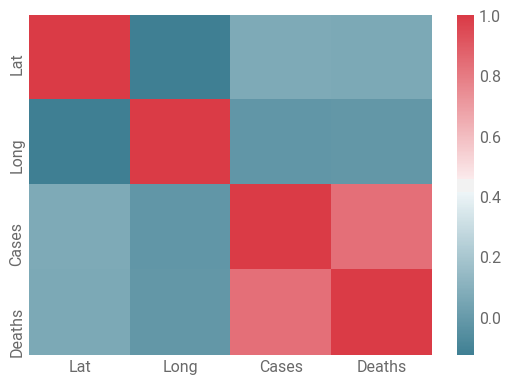

In [13]:
corr = df.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

`sns.pairplot()` is one of my favourite tools to get a quick visual of datasets with not too many features. Not only do we get a plot of each variable against one another, the main diagonal is a distribution plot of the column - nice!

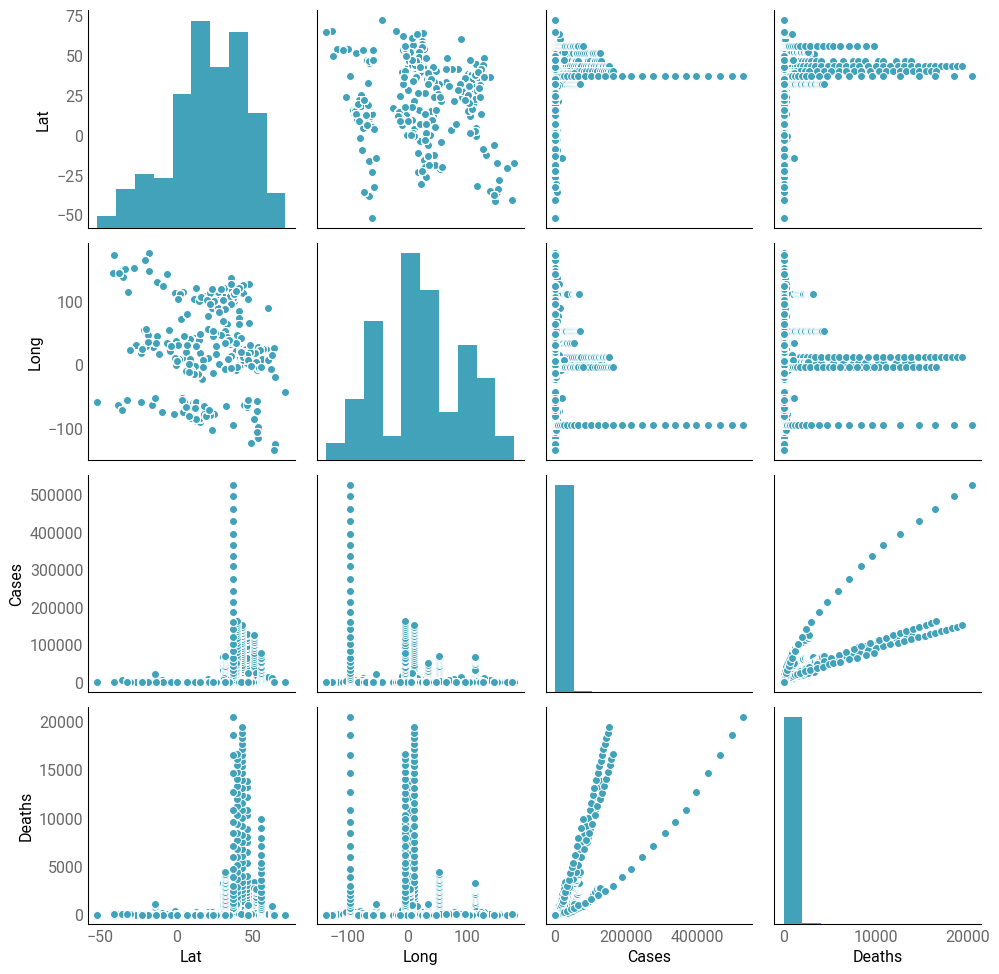

In [14]:
sns.pairplot(df)

**Observations:**
* Looking at the Latitude vs Cases pair plot, it appears that most of the cases (and deaths) are occuring in the northern hemisphere
    * However, if we look at the Latitude distribution plot (the top-left graph), we can see that the distribution of countries in the dataset are more often in the northern hemisphere, so there is nothing crazy going on here :)
* As we would expect, the cases and deaths are generally pretty correlated.
* It isn't particularly useful but it is pretty cool to see that the Lat vs. Long plot roughly draws out the globe :)

In [15]:
# Creating variables that might be useful to reference later
last_data_date = df['Date'].max().strftime('%m-%d-%Y')

In [16]:
# Helper function to get the data for a particular country, independent of any provinces it has
def get_country_data(df, country):
    df_country = df.loc[df['country'] == country]
    df_country = df_country.groupby('Date').sum()
    return df_country

In [17]:
top_10_cases = df[df['Date'] == last_data_date].sort_values(by='Cases').tail(10)
top_10_deaths = df[df['Date'] == last_data_date].sort_values(by='Deaths').tail(10)

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

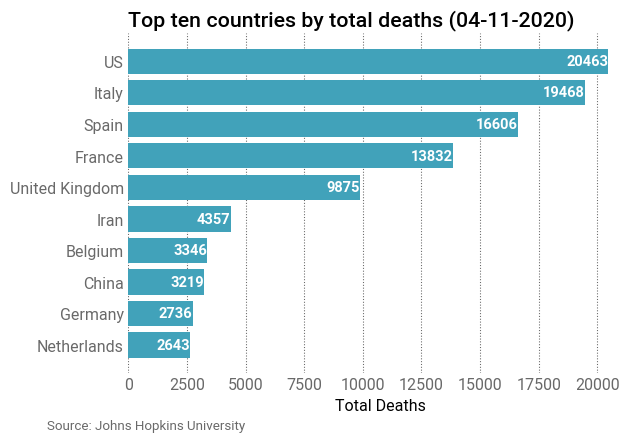

In [18]:
fig, ax = plt.subplots()
title = f'Top ten countries by total deaths ({last_data_date})'
source = 'Johns Hopkins University'
xlabel = 'Total Deaths'
fig, ax = ep.elegant_barh(fig, ax, top_10_deaths, 'country', 'Deaths', title=title, xlabel=xlabel, source=source, grid=True)
plt.tight_layout

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

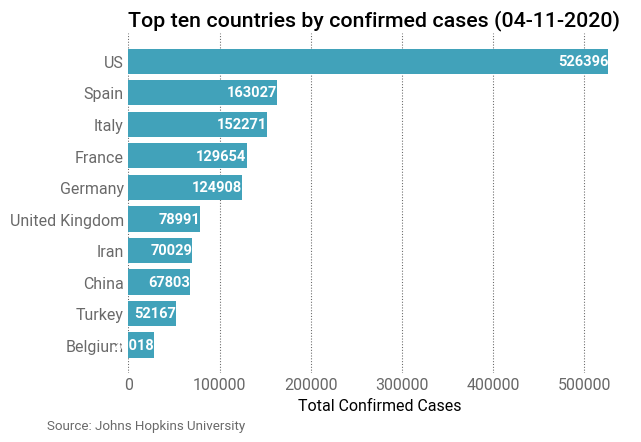

In [19]:
fig, ax = plt.subplots()
title = f'Top ten countries by confirmed cases ({last_data_date})'
source = 'Johns Hopkins University'
xlabel = 'Total Confirmed Cases'
fig, ax = ep.elegant_barh(fig, ax, top_10_cases, 'country', 'Cases', title=title, xlabel=xlabel, source=source, grid=True)
plt.tight_layout

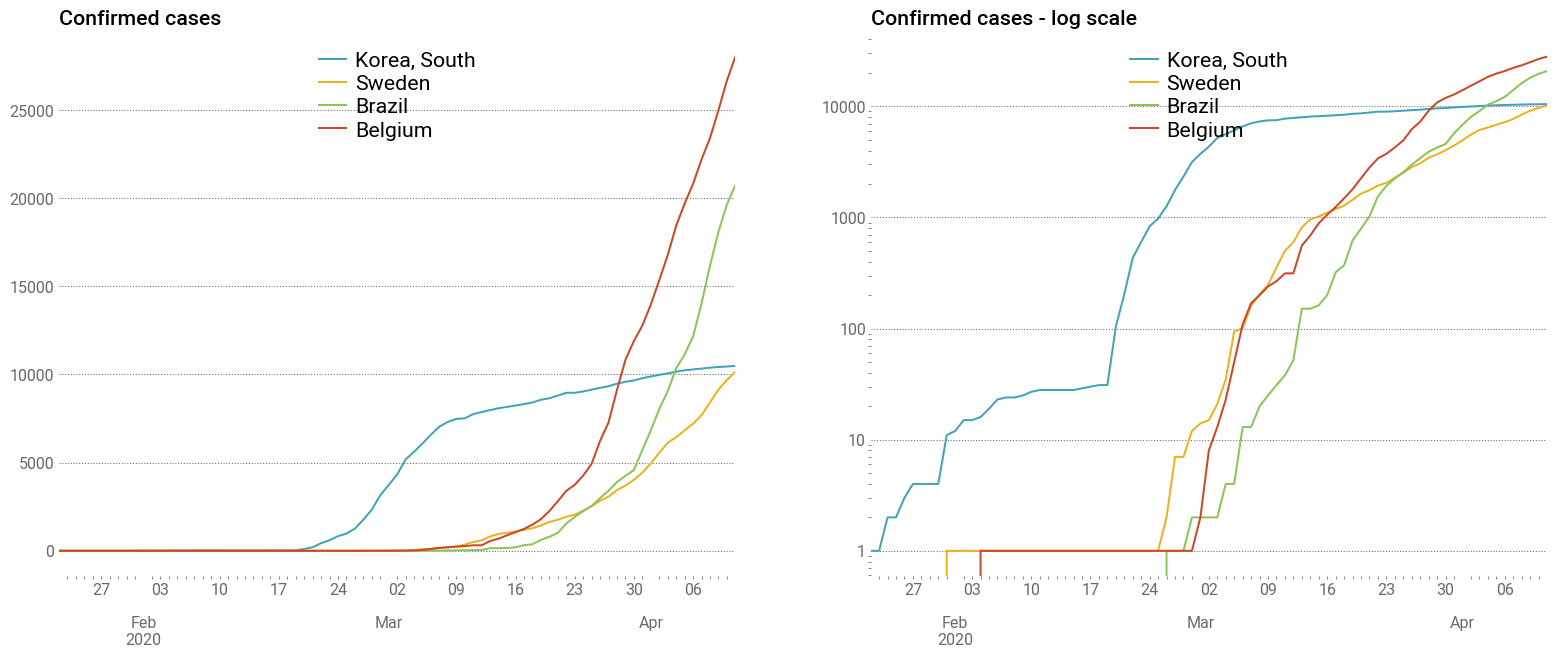

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7.5))
for country in ['Korea, South', 'Sweden', 'Brazil', 'Belgium']:
    df_country = get_country_data(df, country)
    df_country['Cases'].plot(ax=ax1, label=country)
    ax1.set_title('Confirmed cases')
    ax1.grid(True, which='major', axis='y', zorder=0)
    ax1.set_xlabel(None)
    ax1.legend()
    df_country['Cases'].plot(ax=ax2, logy=True, label=country)
    ax2.set_title('Confirmed cases - log scale')
    ax2.grid(True, which='major', axis='y', zorder=0)
    ax2.set_xlabel(None)
    ax2.legend()
    ax2.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax2.ticklabel_format(axis='y', style='plain')
    ax2.tick_params(axis='both', which='both', labelsize=12)

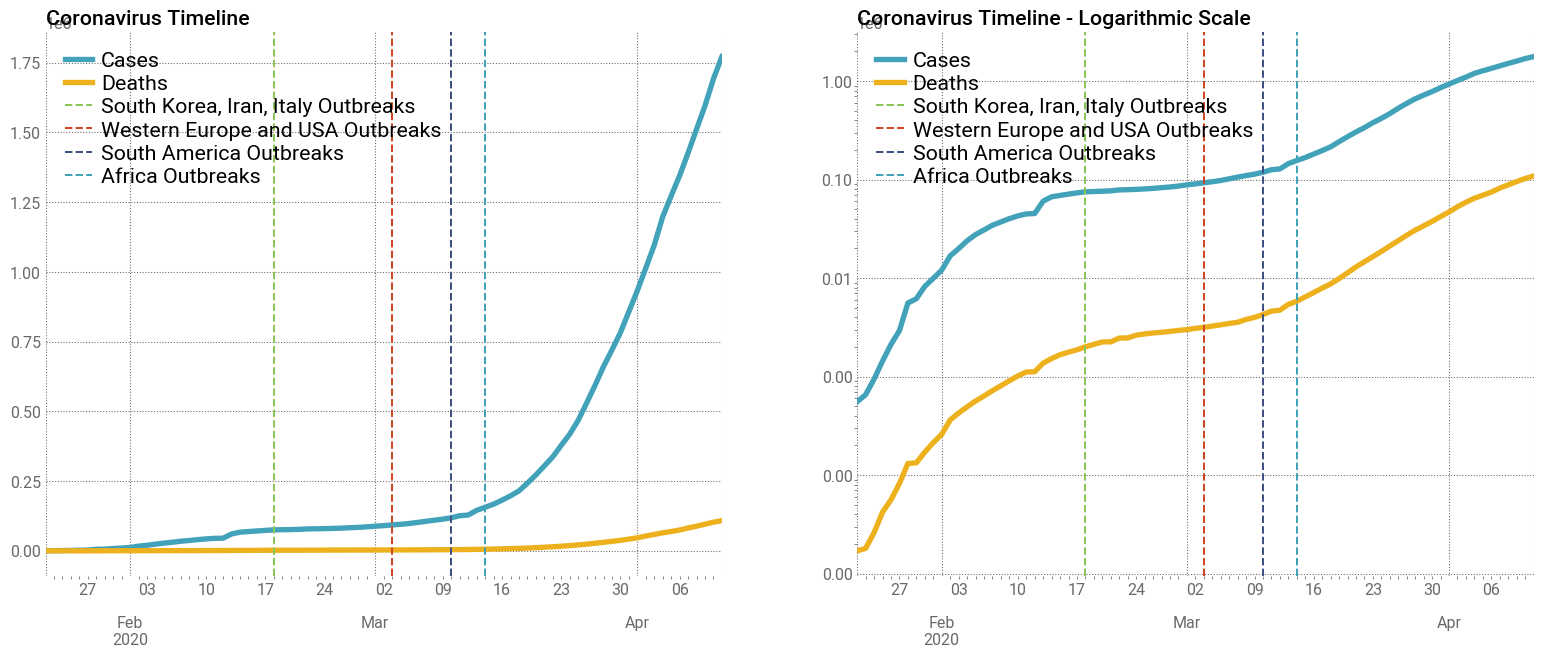

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7.5))
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
df_world = df.groupby('Date').sum()
df_world['Cases'].plot(ax=ax1, linewidth=4)
df_world['Deaths'].plot(ax=ax1, linewidth=4)
df_world['Cases'].plot(ax=ax2, logy=True, linewidth=4)
df_world['Deaths'].plot(ax=ax2, logy=True, linewidth=4)
ax1.axvline('02-18-2020', ls='--', c=colours[2], label='South Korea, Iran, Italy Outbreaks')
ax2.axvline('02-18-2020', ls='--', c=colours[2], label='South Korea, Iran, Italy Outbreaks')
ax1.axvline('03-03-2020', ls='--', c=colours[3], label='Western Europe and USA Outbreaks')
ax2.axvline('03-03-2020', ls='--', c=colours[3], label='Western Europe and USA Outbreaks')
ax1.axvline('03-10-2020', ls='--', c=colours[4], label='South America Outbreaks')
ax2.axvline('03-10-2020', ls='--', c=colours[4], label='South America Outbreaks')
ax1.axvline('03-14-2020', ls='--', c=colours[5], label='Africa Outbreaks')
ax2.axvline('03-14-2020', ls='--', c=colours[5], label='Africa Outbreaks')
ax1.grid(b=True, which='major', axis='both')
ax1.legend(loc='upper left')
ax1.set_xlabel(None)
ax1.tick_params(axis='both', which='both', labelsize=12)
ax1.set_title('Coronavirus Timeline')
ax2.set_title('Coronavirus Timeline - Logarithmic Scale')
ax2.grid(b=True, which='major', axis='both')
ax2.legend(loc='upper left')
ax2.set_xlabel(None)
ax2.tick_params(axis='both', which='both', labelsize=12)
ax2.yaxis.set_major_formatter(mticker.ScalarFormatter())

**TO DO (OR TRY):**
* Add continent data
    * Perform group by on continents - averages, counts, max, std
    * If you do a mean for each day (based on continent), you can see how each continent has fared
    * Can do plots like count (of some feature) vs. mean (of another feature)
* Plot graphs of multiple variables on barh graphs
    * e.g. df[['col1', 'col2']].sort_values(by=['col1', 'col2'], ascending=True).plot(kind='barh')
* Use interactive sliders to do time series - it's easier (I think) and more flexible
* Do a semi-log plot of deaths vs time with each country's curve starting from date of 50th death

# USA confirmed cases and deaths

In [22]:
display(usa_cases.head(6))
display(usa_deaths.head(6))

,iso3,FIPS,county,state,Lat,Long,Combined_Key,1/22/20,1/23/20,1/24/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,ASM,60.0,NaN,American Samoa,-14.271000,-170.132000,"American Samoa, US",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,GUM,66.0,NaN,Guam,13.444300,144.793700,"Guam, US",0,0,0,...,82,84,93,112,113,121,121,128,130,133
2,MNP,69.0,NaN,Northern Mariana Islands,15.097900,145.673900,"Northern Mariana Islands, US",0,0,0,...,6,6,6,6,6,6,6,6,6,6
3,PRI,72.0,NaN,Puerto Rico,18.220800,-66.590100,"Puerto Rico, US",0,0,0,...,316,316,452,475,513,573,620,683,725,788
4,VIR,78.0,NaN,Virgin Islands,18.335800,-64.896300,"Virgin Islands, US",0,0,0,...,30,37,40,42,43,43,45,45,50,51
5,USA,1001.0,Autauga,Alabama,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,...,10,12,12,12,12,12,12,15,17,19


,iso3,FIPS,county,state,Lat,Long,Combined_Key,population,1/22/20,1/23/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,ASM,60.0,NaN,American Samoa,-14.271000,-170.132000,"American Samoa, US",55641,0,0,...,0,0,0,0,0,0,0,0,0,0
1,GUM,66.0,NaN,Guam,13.444300,144.793700,"Guam, US",164229,0,0,...,3,4,4,4,4,4,4,4,4,5
2,MNP,69.0,NaN,Northern Mariana Islands,15.097900,145.673900,"Northern Mariana Islands, US",55144,0,0,...,1,1,1,1,1,1,1,1,1,1
3,PRI,72.0,NaN,Puerto Rico,18.220800,-66.590100,"Puerto Rico, US",2933408,0,0,...,12,15,18,20,21,23,24,33,39,42
4,VIR,78.0,NaN,Virgin Islands,18.335800,-64.896300,"Virgin Islands, US",107268,0,0,...,0,0,0,1,1,1,1,1,1,1
5,USA,1001.0,Autauga,Alabama,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,...,0,0,0,0,0,1,1,1,1,1


In [23]:
from tqdm import tqdm
def transform_df(df, measured_val='Cases'):
    if measured_val == 'Cases':
        dict = {'county': [], 'state': [], 'iso3': [], 'FIPS': [], 'Date': [], 'Lat': [], 'Long': [], 'Combined_Key': [], measured_val: []}
    else:
        dict = {'county': [], 'state': [], 'iso3': [], 'FIPS': [], 'Date': [], 'Lat': [], 'Long': [], 'population': [], 'Combined_Key': [], measured_val: []}
    for index, row in tqdm(df.iterrows()):
        columns = list(df)
        for i, value in enumerate(row[8:]):           
            dict['county'].append(row['county'])
            dict['state'].append(row['state'])
            dict['iso3'].append(row['iso3'])
            dict['FIPS'].append(row['FIPS'])
            dict['Date'].append(columns[i+8])
            dict['Lat'].append(row['Lat'])
            dict['Long'].append(row['Long'])
            dict['Combined_Key'].append(row['Combined_Key'])
            if measured_val != 'Cases':
                dict['population'].append(row['population'])
            dict[measured_val].append(value)
    new_df = pd.DataFrame(data=dict)
    return new_df

usa_cases_transformed = transform_df(usa_cases)
usa_deaths_transformed = transform_df(usa_deaths, measured_val='Deaths')
usa_cases_transformed.to_csv('/home/maxbe/git/data_science/COVID-19/data/usa_cases_transformed.csv', index=False)
usa_deaths_transformed.to_csv('/home/maxbe/git/data_science/COVID-19/data/usa_deaths_transformed.csv', index=False)

3253it [00:12, 252.99it/s]
3253it [00:13, 233.21it/s]


In [33]:
usa_cases = pd.read_csv('/home/maxbe/git/data_science/COVID-19/data/usa_cases_transformed.csv', index_col=False)
usa_deaths = pd.read_csv('/home/maxbe/git/data_science/COVID-19/data/usa_deaths_transformed.csv', index_col=False)
usa_cases = usa_cases[usa_cases['county'] != 'Unassigned']
usa_deaths = usa_deaths[usa_deaths['county'] != 'Unassigned']

In [39]:
usa_cases['Date'] = pd.to_datetime(usa_cases['Date'])
usa_deaths['Date'] = pd.to_datetime(usa_deaths['Date'])
usa_cases_today = usa_cases[usa_cases['Date'] == last_data_date]
usa_deaths_today = usa_deaths[usa_deaths['Date'] == last_data_date]
usa_cases_today.groupby(by='state', as_index=False)
usa_deaths_today.groupby(by='state', as_index=False)

In [40]:
usa_states_cases_today.sortvalues()

AttributeError: 'DataFrameGroupBy' object has no attribute 'sortvalues'

In [ ]:
fig, ax = plt.subplots()
title = f'Top ten states by confirmed cases ({last_data_date})'
source = 'Johns Hopkins University'
xlabel = 'Total Confirmed Deaths'
fig, ax = ep.elegant_barh(fig, ax, top_10_states_deaths, 'state', 'Deaths', title=title, xlabel=xlabel, source=source, grid=True)
ax.ticklabel_format(axis='x', style='plain')
ax.set_xticklabels([0, '250K', '500K', '750K', '1M', '1.25M', '1.5M', '1.75M', '2M'])
plt.tight_layout